## 1. Vehicle Routing Problem

In [22]:
import numpy as np
from Numberjack import *
import matplotlib.pyplot as plt
import networkx as ntx
import random


a) rede de estradas <=> grafo orientado

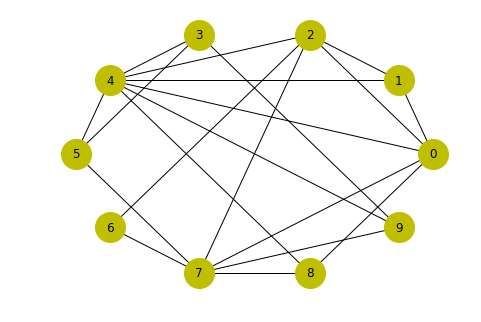

EdgeDataView([(0, 1, {'weight': 6}), (0, 2, {'weight': 4}), (0, 4, {'weight': 7}), (0, 7, {'weight': 4}), (0, 8, {'weight': 1}), (1, 2, {'weight': 5}), (1, 4, {'weight': 1}), (2, 4, {'weight': 7}), (2, 6, {'weight': 9}), (2, 7, {'weight': 5}), (3, 9, {'weight': 5}), (3, 4, {'weight': 1}), (3, 5, {'weight': 1}), (4, 5, {'weight': 6}), (4, 8, {'weight': 2}), (4, 9, {'weight': 7}), (5, 7, {'weight': 5}), (6, 7, {'weight': 2}), (7, 8, {'weight': 3}), (7, 9, {'weight': 3})])

In [23]:

Nodes = 10
Carros = 3
NumClientes = 6

g = ntx.DiGraph()
g = ntx.connected_watts_strogatz_graph(Nodes,4,0.5)

for i, j in g.edges():
    r = np.random.randint(1,10)
    g.add_edge(i,j,weight = r)
    g.add_edge(j,i,weight = r)

ntx.draw_shell(g,arrows=False,node_size=900,node_color='y',with_labels=True)
plt.show()

g.edges(data = True)

b)  $C_{i,j}$ e $t_{i,j}$ 

os carros começam no nodo 0

[0, 4, 4, 4, 3, 5, 6, 4, 1, 7]
[4, 0, 5, 2, 1, 3, 8, 6, 3, 7]
[4, 5, 0, 7, 6, 8, 7, 5, 5, 8]
[4, 2, 7, 0, 1, 1, 8, 6, 3, 5]
[3, 1, 6, 1, 0, 2, 7, 5, 2, 6]
[5, 3, 8, 1, 2, 0, 7, 5, 4, 6]
[6, 8, 7, 8, 7, 7, 0, 2, 5, 5]
[4, 6, 5, 6, 5, 5, 2, 0, 3, 3]
[1, 3, 5, 3, 2, 4, 5, 3, 0, 6]
[7, 7, 8, 5, 6, 6, 5, 3, 6, 0]


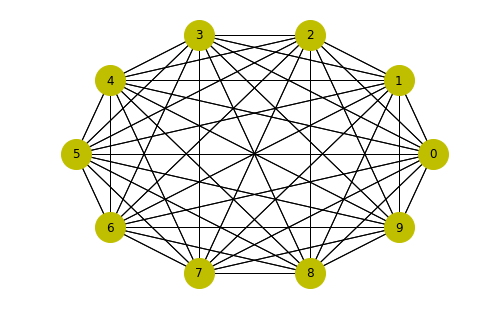

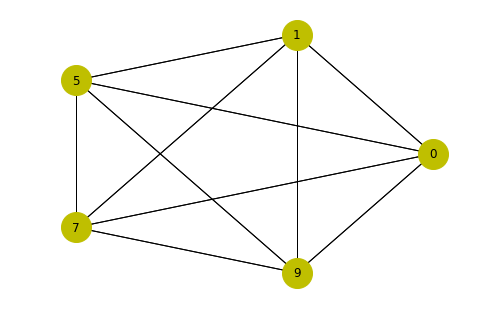

In [24]:
G = ntx.DiGraph()

G.add_nodes_from(g)
EdgesP = []

#inicializar a matriz
for i in range(Nodes):
    EdgesP.append([])
    for j in range(Nodes):
        EdgesP[i].append(-1)
        
#colocar os pesos ja calculados
for i, j, p in g.edges(data = True):
    w = p['weight']
    EdgesP[j][i] = EdgesP[i][j] = w
    G.add_edge(i, j, weight = w)
    G.add_edge(j, i, weight = w)

#calcular os caminhos mais curtos
dic = ntx.shortest_path(G, weight = 'weight')

#colocar os menores pesos
for i in range(Nodes):
    for j in range(Nodes):
        w = 0
        for k in range(len(dic[i][j])-1):
            i1 = dic[i][j][k]
            i2 = dic[i][j][k+1]
            w += EdgesP[i1][i2]
        EdgesP[i][j] = w
        G.add_edge(i,j,weight = w)
        
#criar clientes
Clientes = np.unique(np.random.choice(range(1,Nodes), NumClientes))
NumClientes = len(Clientes)

for i in EdgesP:
    print(i)

'''
print(dic[2][4],dic[4][2])
#print(peso(2,4,G), peso(4,2,G))
print(min(sum([ peso(dic[2][4][i],dic[2][4][i+1],G) for i in range(len(dic[2][4])-1)]), \
      sum([ peso(dic[4][2][i],dic[4][2][i+1],G) for i in range(len(dic[4][2])-1)])))

for k1 in range(Nodes):
    for k2 in range(Nodes):
        w = min(sum([ peso(dic[k1][k2][i],dic[k1][k2][i+1],EdgesP) for i in range(len(dic[k1][k2])-1)]),\
                sum([ peso(dic[k2][k1][i],dic[k2][k1][i+1],EdgesP) for i in range(len(dic[k2][k1])-1)]))
        
        #for i in range(len(l)-1):
        #    w += procura(l[i],l[i+1],EdgesP)
        #if((k1==2 or k1==4) and (k2==2 or k2==4)):
        #    print(w)
        #if((k2,k1,w) in EdgesP and w > procura(k1,k2,EdgesP)):
        #    w = procura(k1,k2,EdgesP)
        
        #EdgesP.add((k1,k2,w))
        #EdgesP.add((k2,k1,w))
        #print(procura(2,4,EdgesP), procura(4,2,EdgesP))
        G.add_edge(k1,k2, weight = w)
        G.add_edge(k2,k1, weight = w)

Clientes = np.unique(np.random.choice(range(1,Nodes), NumClientes))
print(Clientes)
print(G.edges(data = True))

Rotas = [VarArray(Nodes*3,Nodes) for i in range (Carros)]
'''
#print(G.edges(data=True))
ntx.draw_shell(G,arrows=False,node_size=900,node_color='y',with_labels=True)
plt.show()

G_clientes = G.copy()

for i in range(Nodes):
    if(i not in Clientes and i != 0 ):
        G_clientes.remove_node(i)


ntx.draw_shell(G_clientes,arrows=False,node_size=900,node_color='y',with_labels=True)
plt.show()

c) Restrições

In [37]:
'''
aux=[]
model=Model()
for i in Rotas:
    model.add(i[0]==0)
    w = 0
    for j in range(1,Nodes*3-1):        
        if(i[j]==0):
            model.add(i[j+1]==0)
        else:
            model.add(i[j] in Clientes)
            w += procura(i[j],i[j+1],EdgesP)
            if j-1==0:
                w += procura(0,i[1],EdgesP)
            if(i[j] not in aux):
                aux.append(i[j])

model.add(Minimize(w))
#if (aux==Clientes.tolist()):
print(model.load('SCIP').solve())

          
          
#model.add(Minimize(c))        
#model.add(set(aux)==set(Clientes))
#model.add(Minimize(w))

#print(model)
#print(Clientes)
#print(set(Clientes))
'''

Mat = Matrix(Carros,Nodes**2)
model = Model()

#Obrigar a que as arestas do tipo (i,i) sejam 0

for c in range(Carros):
    for n in range(Nodes):
        model.add(Mat[c][n*Nodes+n]==0)
        
#Obrigar os clientes a serem atendidos

for c in Clientes.tolist():
    A = [ Mat[i][c*Nodes+j] for i in range(Carros) for j in range(Nodes) ]
    model.add( Sum(A) > 1 )

#Obrigar a começar e acabar no 0

for c in range(Carros):
    model.add( Sum([ Mat[c][0*Nodes + i] for i in range(Nodes)]) == 1 )
    model.add( Sum([ Mat[c][i*Nodes + 0] for i in range(Nodes)]) == 1 )
            
            
#Minimizar o custo

for c in range(Carros):
    model += Minimise(Sum([ EdgesP[i//Nodes][i%Nodes]*Mat[c][i] for i in range(Nodes**2)]))

#Minimizar os carros

#model += Minimise(Sum([  ]))

#Verificar que o caminho faz sentido
'''
L = [0]*Nodes

for c in range(Carros):
    for i in range(Nodes):
        for j in range(Nodes):
            L[i] += Mat[c][j*Nodes+i]
            L[i] -= Mat[c][i*Nodes+j]
    model.add( Sum(L) == 0 )
'''
print()
#print(model)
#model.load('SCIP').solve()

In [38]:
print(Mat)

    

[[x0.0 in {0,1}, x0.1 in {0,1}, x0.2 in {0,1}, x0.3 in {0,1}, x0.4 in {0,1}, x0.5 in {0,1}, x0.6 in {0,1}, x0.7 in {0,1}, x0.8 in {0,1}, x0.9 in {0,1}, x0.10 in {0,1}, x0.11 in {0,1}, x0.12 in {0,1}, x0.13 in {0,1}, x0.14 in {0,1}, x0.15 in {0,1}, x0.16 in {0,1}, x0.17 in {0,1}, x0.18 in {0,1}, x0.19 in {0,1}, x0.20 in {0,1}, x0.21 in {0,1}, x0.22 in {0,1}, x0.23 in {0,1}, x0.24 in {0,1}, x0.25 in {0,1}, x0.26 in {0,1}, x0.27 in {0,1}, x0.28 in {0,1}, x0.29 in {0,1}, x0.30 in {0,1}, x0.31 in {0,1}, x0.32 in {0,1}, x0.33 in {0,1}, x0.34 in {0,1}, x0.35 in {0,1}, x0.36 in {0,1}, x0.37 in {0,1}, x0.38 in {0,1}, x0.39 in {0,1}, x0.40 in {0,1}, x0.41 in {0,1}, x0.42 in {0,1}, x0.43 in {0,1}, x0.44 in {0,1}, x0.45 in {0,1}, x0.46 in {0,1}, x0.47 in {0,1}, x0.48 in {0,1}, x0.49 in {0,1}, x0.50 in {0,1}, x0.51 in {0,1}, x0.52 in {0,1}, x0.53 in {0,1}, x0.54 in {0,1}, x0.55 in {0,1}, x0.56 in {0,1}, x0.57 in {0,1}, x0.58 in {0,1}, x0.59 in {0,1}, x0.60 in {0,1}, x0.61 in {0,1}, x0.62 in {0,1}, 

## 2. Sudoku

In [27]:
N = 3
NS = N*N
Gre = Matrix(NS,NS,1,NS)
model = Model()


## Popular a Grelha de Sudoku





Preencher a Grelha
todos os pequenos quadrados têm diferentes números

$\forall_{i< N²}\forall_{j< N²}\forall_{i<i2\leq N²}
\forall_{j<j2\leq N²}\big(M[i,j] =M[i2,j2] \Rightarrow \big(i/N \neq i2/N\big) \vee \big(j/N \neq j2/N\big)  \big)$
        
todas as linhas têm diferentes números

$\forall_{i\leq N²}\forall_{j< N²}\forall_{j<j2\leq N²}\big(M[i,j] \neq M[i,j2] \big)$

todas as colunas têm diferentes números

$\forall_{i< N²}\forall_{i<i2\leq N²}\forall_{j\leq N²}\big(M[i,j] \neq M[i2,j] \big)$


In [28]:
for i in range(N):
    for j in range(N):
        model.add(AllDiff(Gre[i*N:(i+1)*N,j*N:(j+1)*N].flat))
        model.add(AllDiff(Gre[i*N+j]))
        model.add(AllDiff(Gre.col[i*N+j]))



Resolver

In [29]:
model.load('SCIP').solve()

print(Gre)

[[8, 3, 5, 9, 1, 6, 7, 4, 2],
 [7, 6, 9, 4, 5, 2, 3, 1, 8],
 [1, 2, 4, 7, 3, 8, 5, 6, 9],
 [9, 5, 6, 2, 8, 1, 4, 3, 7],
 [3, 8, 7, 6, 9, 4, 1, 2, 5],
 [4, 1, 2, 5, 7, 3, 9, 8, 6],
 [6, 7, 3, 1, 2, 9, 8, 5, 4],
 [2, 9, 1, 8, 4, 5, 6, 7, 3],
 [5, 4, 8, 3, 6, 7, 2, 9, 1]]
